In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
train_dir = r'F:\Bone Frature Project\Test 1.0\dataset\train'
val_dir=r'F:\Bone Frature Project\Test 1.0\dataset\val'

In [ ]:
print(train_dir,val_dir)

F:\Bone Frature Project\Test 1.0\dataset\train F:\Bone Frature Project\Test 1.0\dataset\val


In [ ]:
img_height,img_width=224,224
batch_size=16

def apply_clahe(image):
    # Convert image from float (0-1) to uint8 (0-255)
    image = (image * 255).astype(np.uint8)
    
    # Apply CLAHE to each channel (for RGB images)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    image = cv2.merge(clahe_channels)
    
    # Normalize the image to make min value 0 and max value 1
    image = image.astype(np.float32)
    min_val = image.min()
    max_val = image.max()
    
    # Avoid division by zero
    if max_val - min_val != 0:
        image = (image - min_val) / (max_val - min_val)
    
    return image


train_datagen = ImageDataGenerator(
     preprocessing_function=apply_clahe
)

# Load training dataset with augmentation
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',        # Binary classification
    seed=123
)


Found 8683 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function=apply_clahe)  # Note the absence of augmentation
val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',    
    seed=123
)

Found 600 images belonging to 2 classes.


In [ ]:
class_names = train_ds.class_indices
print(class_names)

{'fractured': 0, 'not fractured': 1}


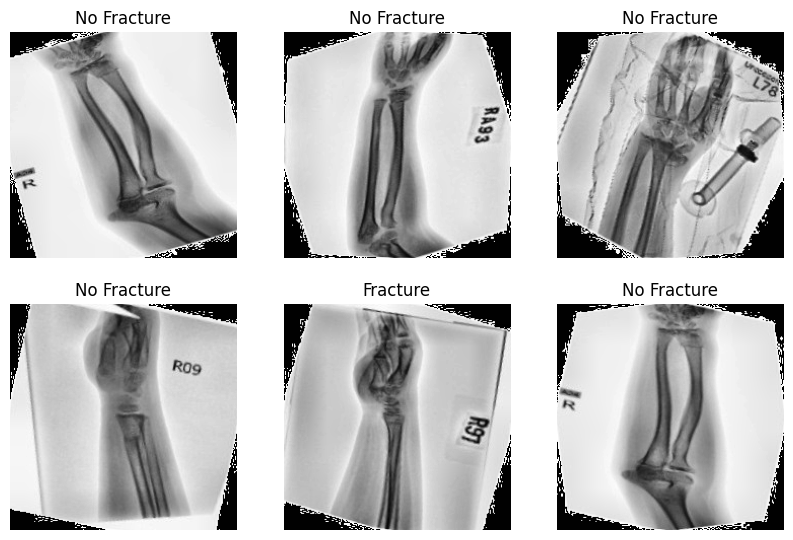

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_ds)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Fracture" if labels[i] == 1 else "No Fracture")  # Assuming binary classification
    plt.axis("off")

plt.show()


In [ ]:

images, labels = next(train_ds)


min_val = images.min()
max_val = images.max()

print(f"Minimum pixel value: {min_val}")
print(f"Maximum pixel value: {max_val}")


Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [ ]:

resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224, 3),
    pooling='avg',
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Flatten())
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))  # Single output unit with sigmoid


In [ ]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,754,177 (14.32 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:


history = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70
)


Epoch 1/50


f:\Bone Frature Project\Test 1.0\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 15/543 ━━━━━━━━━━━━━━━━━━━━ 3:54 443ms/step - accuracy: 0.4855 - loss: 1.6727

KeyboardInterrupt: 

In [ ]:
import pickle

# Save the training history
with open('ResNet50.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy: ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss: ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on validation set
val_preds = mobilenet_model.predict(val_ds)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary classes (0 or 1)

# Get the true labels from the validation set
val_labels = np.concatenate([val_ds[i][1] for i in range(len(val_ds))])

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_preds)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
target_names = ['Not Fractured', 'Fractured']
report = classification_report(val_labels, val_preds, target_names=target_names)
print("Classification Report:\n", report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
